In [1]:
import tensorflow as tf
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
import keras.models
import keras.utils

# Helper libraries
import numpy as np
from scipy import stats,special
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
import math
import time
import h5py

import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc

import innvestigate
import innvestigate.utils as iutils


import os
import keras
import keras.backend
from keras import layers
from keras import models
import keras.utils


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os
import datetime


print('TensorFlow Version {}'.format(tf.__version__))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

TensorFlow Version 1.13.1


In [2]:
def plot_variable(sig_hist, bkg_hist, bins):
    fig=plt.figure(figsize=(6,7))
    ax1 = fig.add_subplot()
    ax1.hist(sig_hist.flatten(), normed=False,weights = np.ones(len(sig_hist.flatten()))/len(sig_hist.flatten()),
             histtype='step', alpha=0.55, facecolor='#1f77b4', bins=bins, lw=2,
             label='Signal', hatch='/', edgecolor='k', fill=True)
    ax1.hist(bkg_hist.flatten(), normed=False, weights = np.ones(len(bkg_hist.flatten()))/len(bkg_hist.flatten()),
            histtype='step',alpha=0.55, facecolor='#ff7f0e', bins=bins, lw=2,
            label='Background', hatch='\\', edgecolor='k', fill=True)
    minx= np.min([np.min(sig_hist.flatten()), np.min(bkg_hist.flatten())])
    maxx= np.max([np.max(sig_hist.flatten()), np.max(bkg_hist.flatten())])
    ax1.set_xlim(minx,maxx)
    ax1.legend(loc='upper center')
    ax1.set_ylabel('Fraction')
    plt.show()

In [3]:
# load output files from Showjets.ipynb

data = np.load('/mnt/data/ml/Constituent4vec_addmoretaus.npz')
jetdata = np.load('/mnt/data/ml/ShowJetsData_addmoretaus.npz')

In [4]:
labels = data['labels']
jetlabels = jetdata['labels']
# make size of zz and qcd the same
numData = np.min([np.sum(jetdata['labels'][:,1]==1), np.sum(jetdata['labels'][:,0]==1)])
# size of expert variables
print(numData)

882778


In [5]:
# variables to get from "jetdata" npz file

xaugs = ['chMult',
        'jetpull',
        'tau2_b05',
        'tau3_b05',
        'tau2_sd_b05',
        'tau3_sd_b05',
        'jetMass',
        'jetMassSD',
         'labels'
        ]


# variables to get from "data" (constituents) npz file

particle_list_vars = ['jetconstPt_log',
                      'jetconstEta_abs',
                      'jetconstE_log',
                      'jetconstPt_Jetlog',
#                       'charge',
#                       'isEle',
#                       'isPho',
#                       'isMuon',
#                       'isCh',
#                       'isNh',
                      'delta_eta',
                      'delta_phi',
                      'deltaR_jet',
                      'deltaR_subjet0',
                      'deltaR_subjet1',
                      'dxy',
                      'dz'
                     ]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


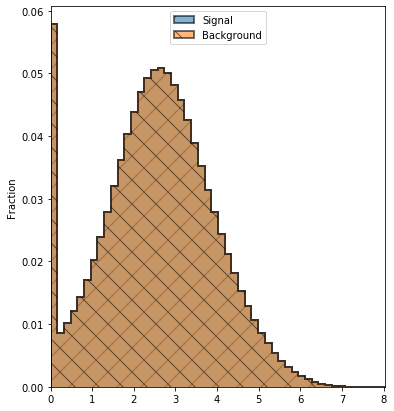

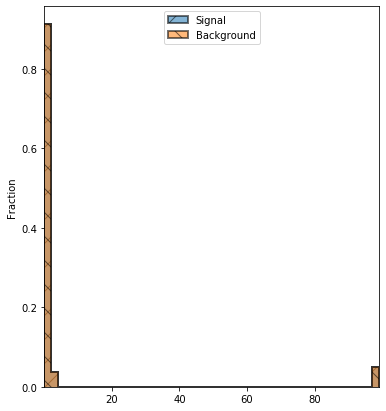

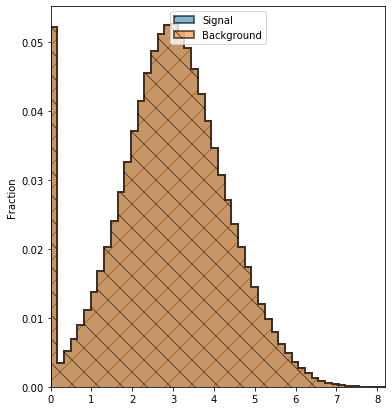

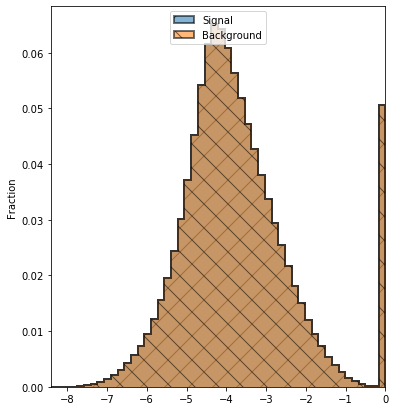

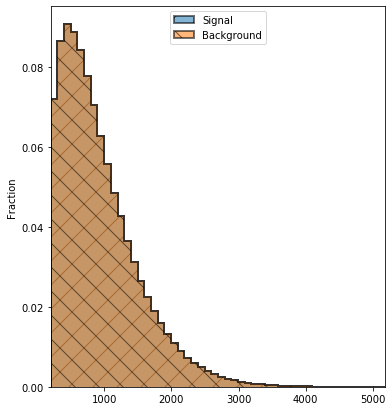

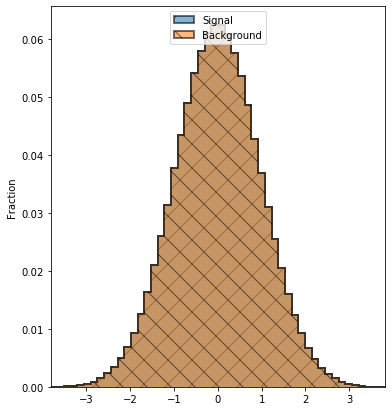

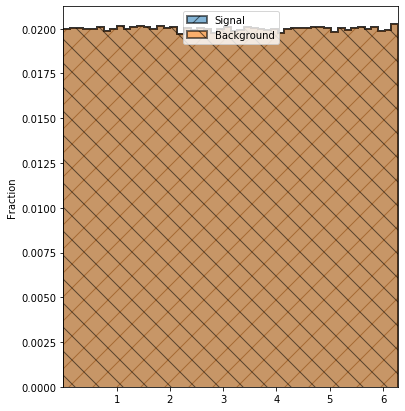

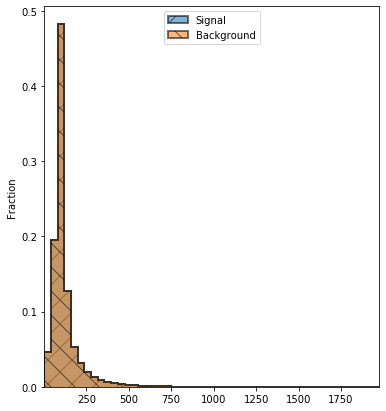

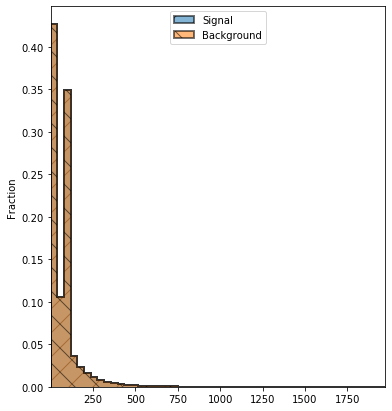

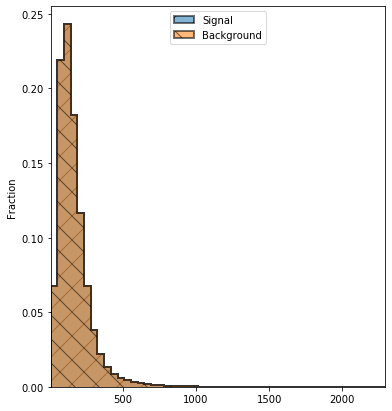

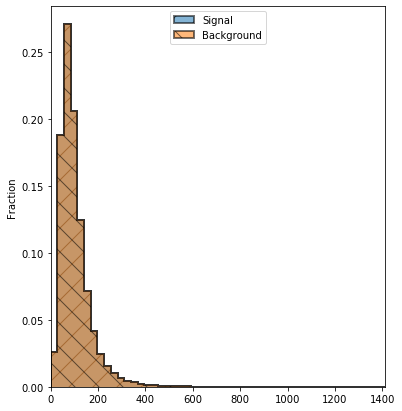

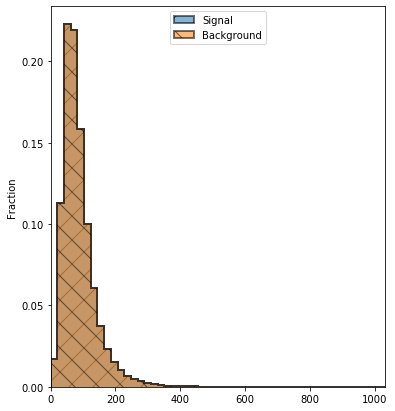

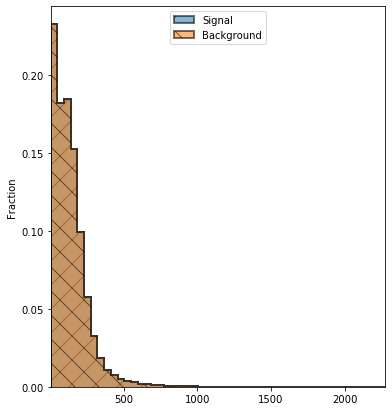

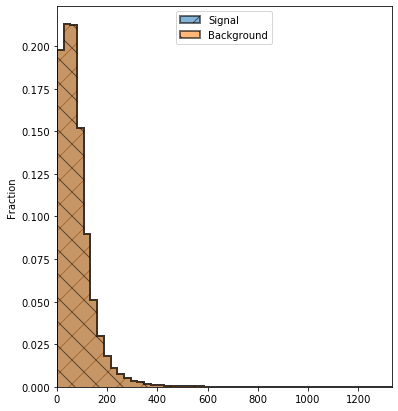

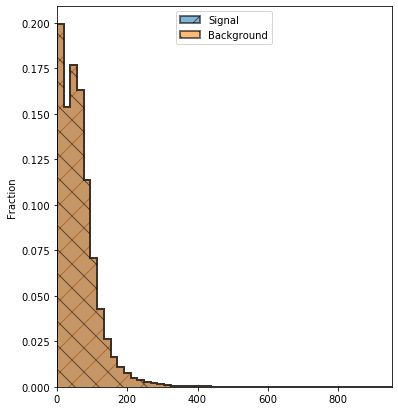

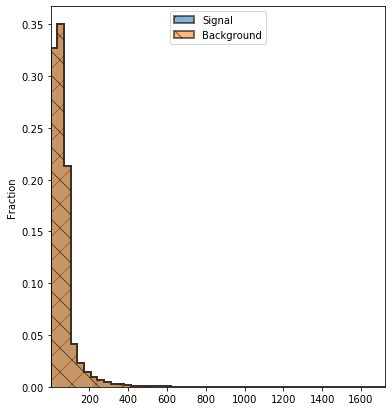

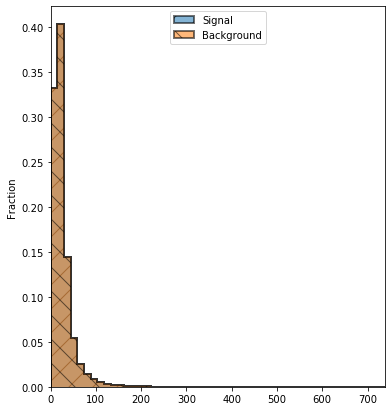

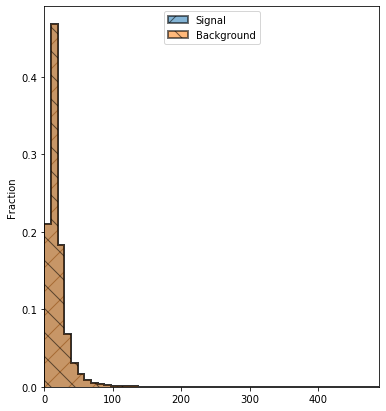

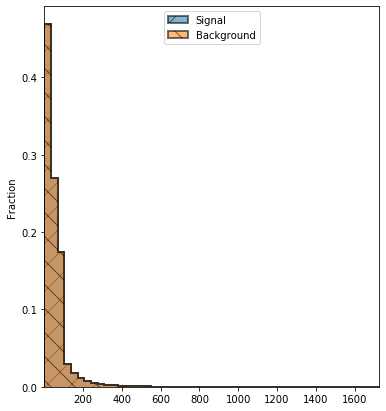

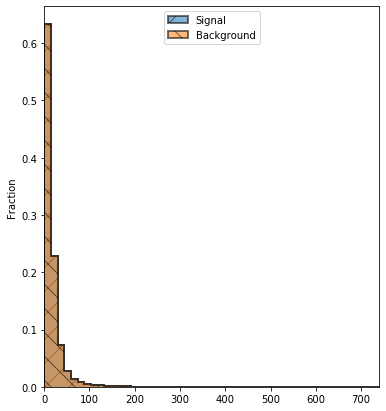

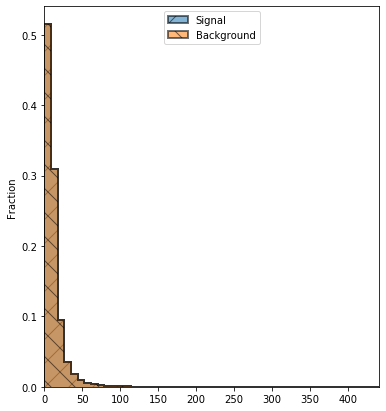

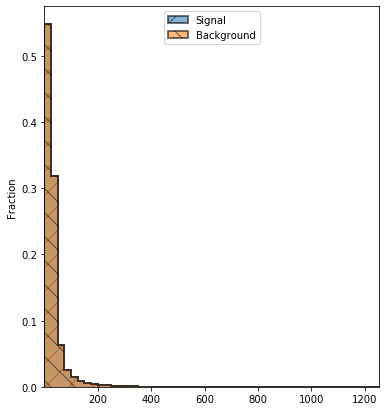

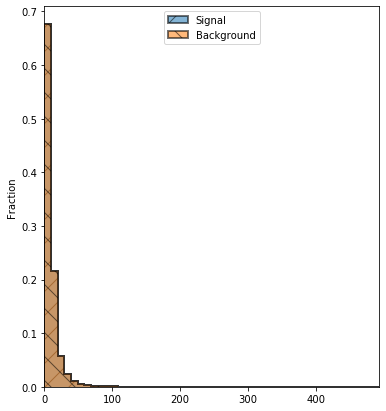

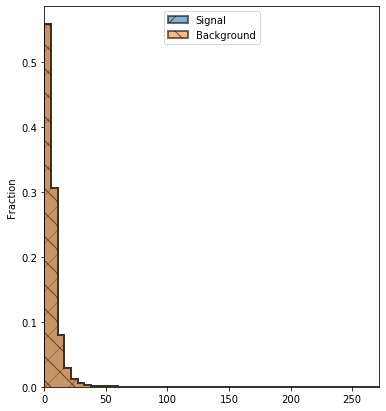

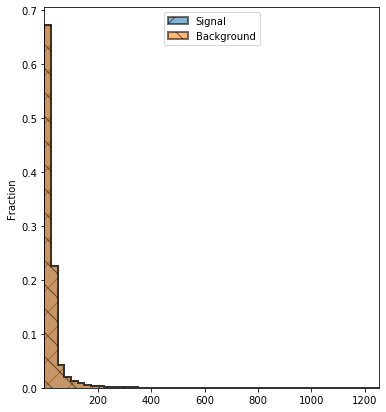

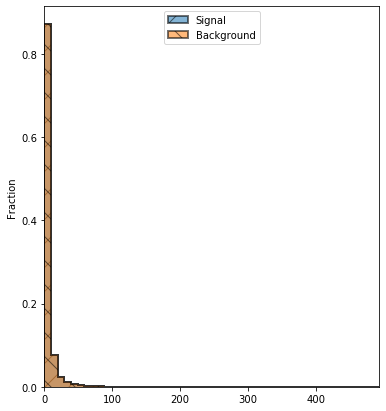

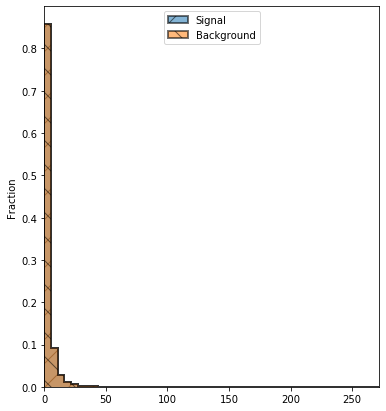

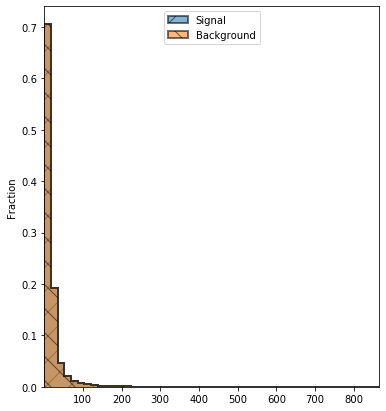

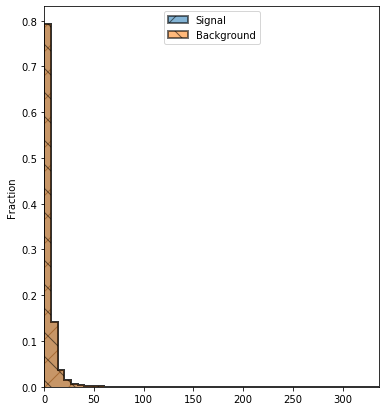

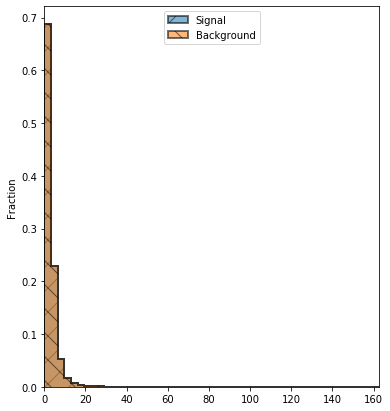

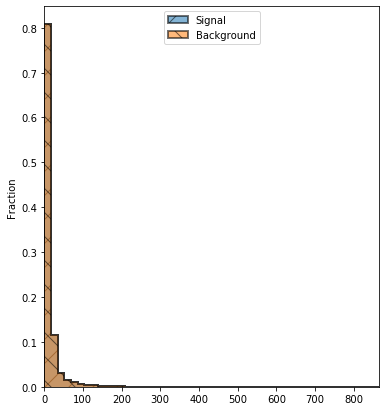

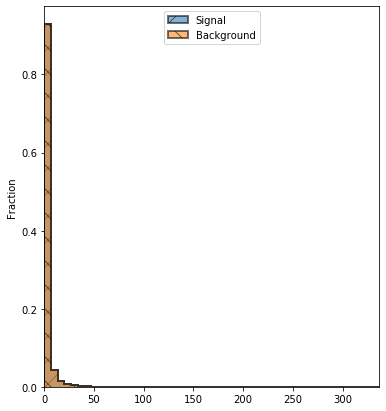

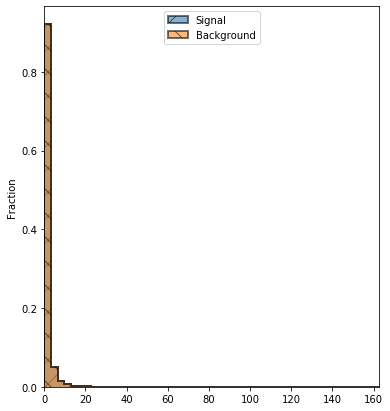

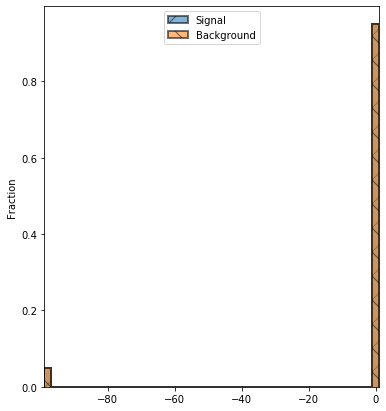

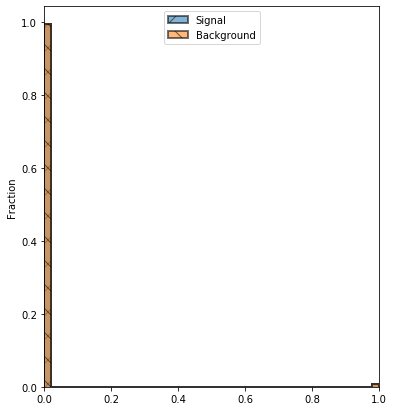

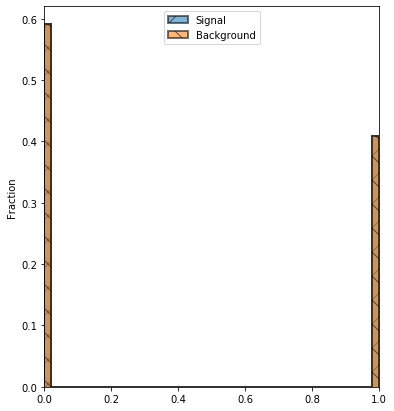

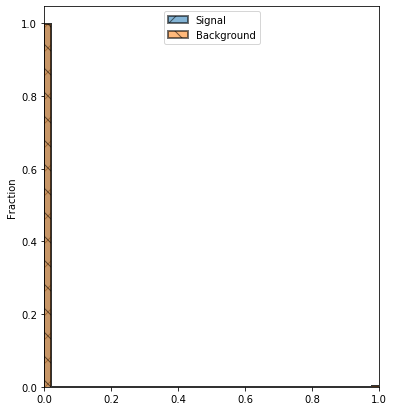

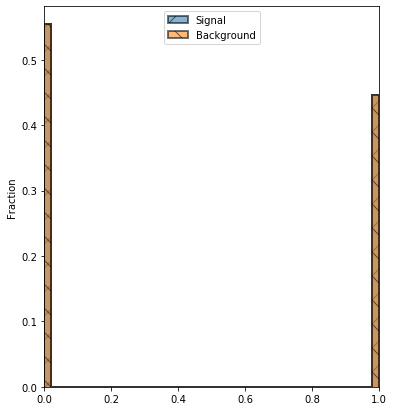

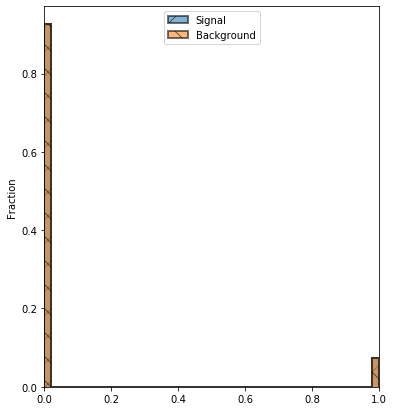

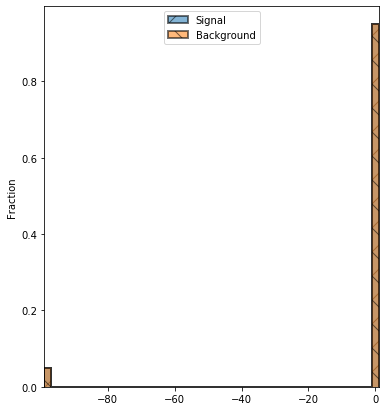

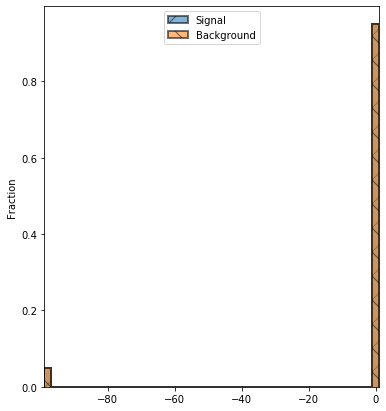

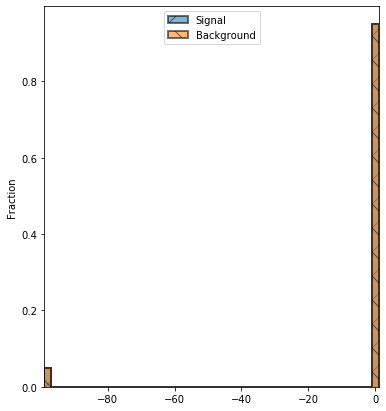

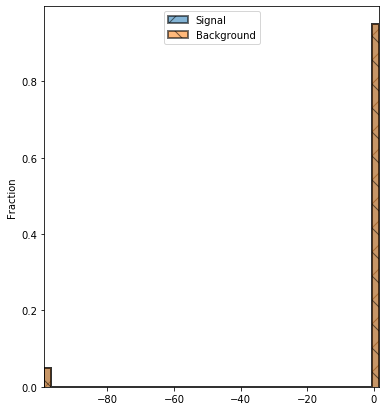

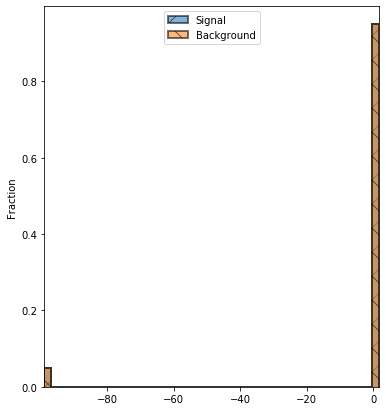

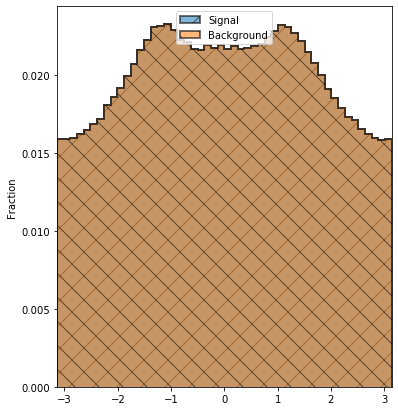

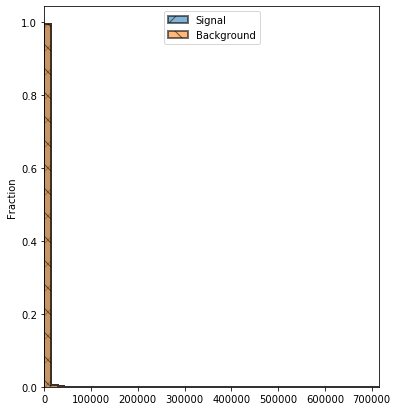

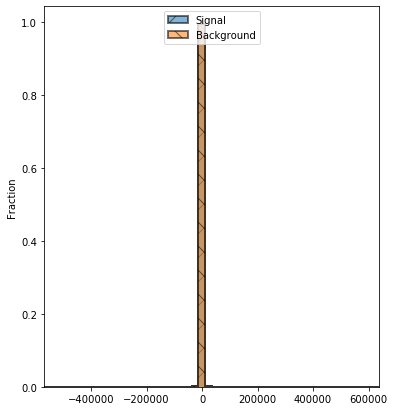

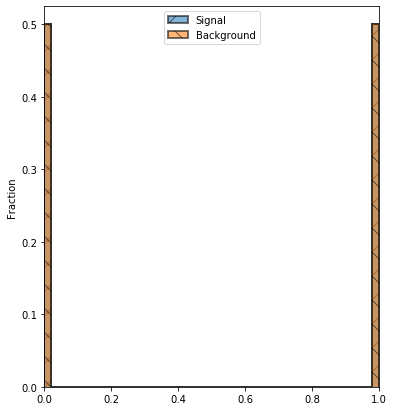

Now add in rebinning


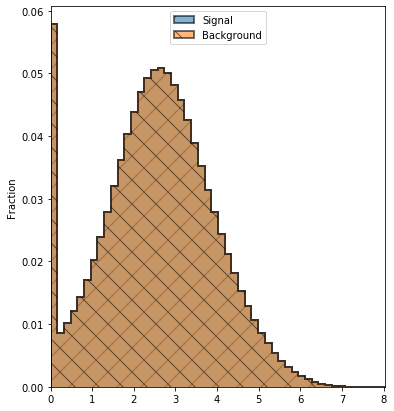

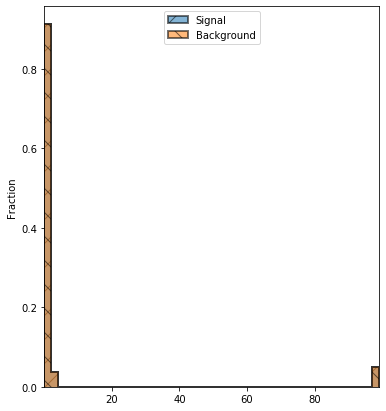

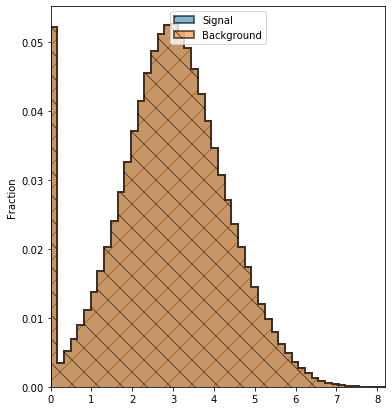

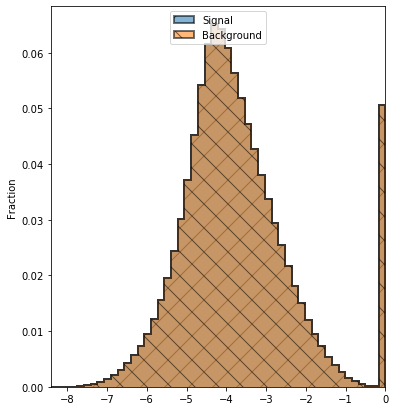

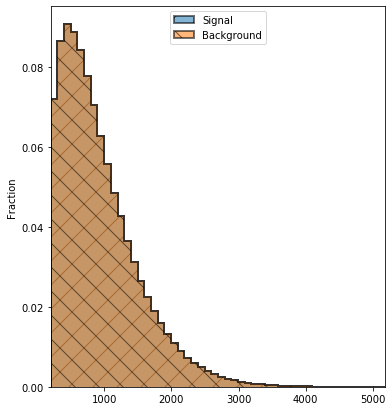

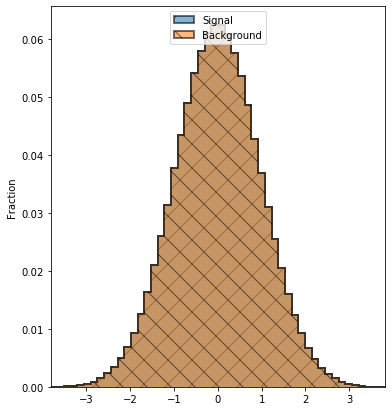

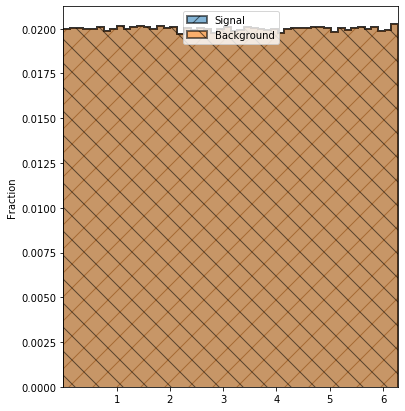

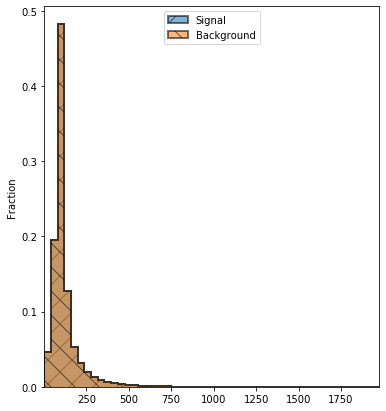

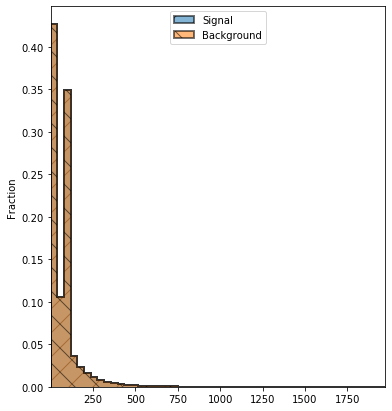

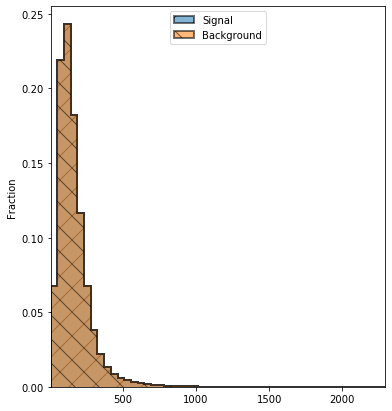

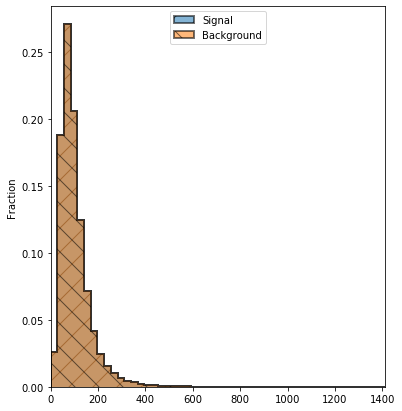

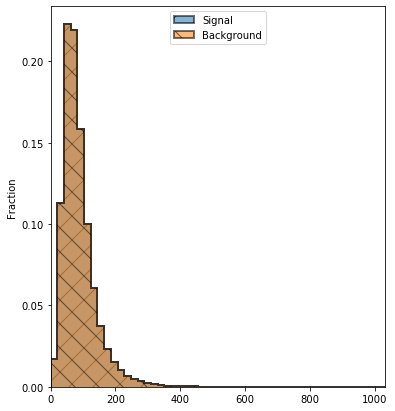

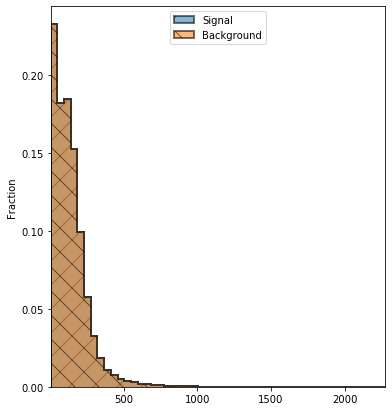

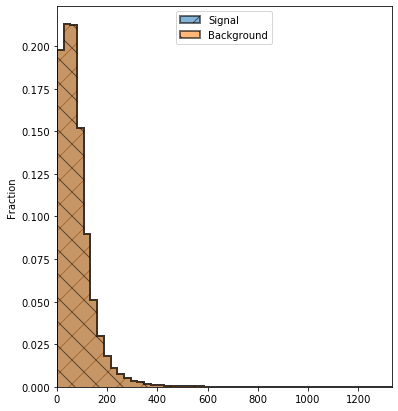

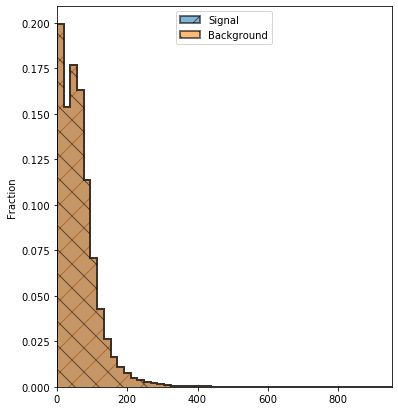

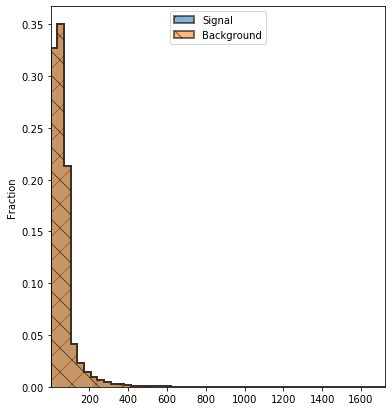

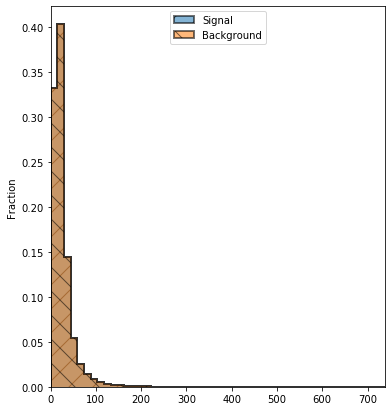

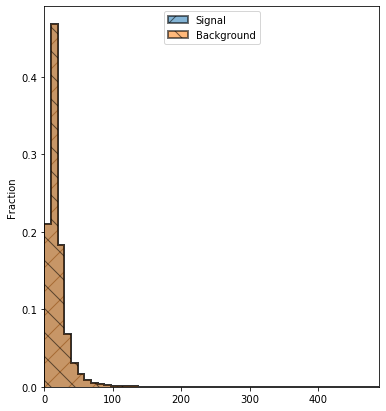

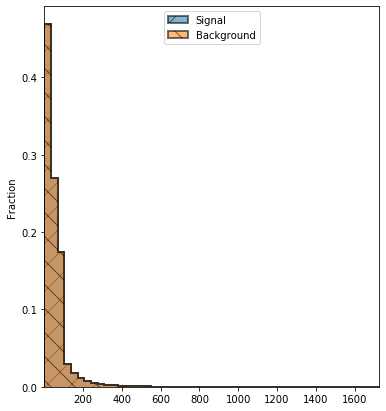

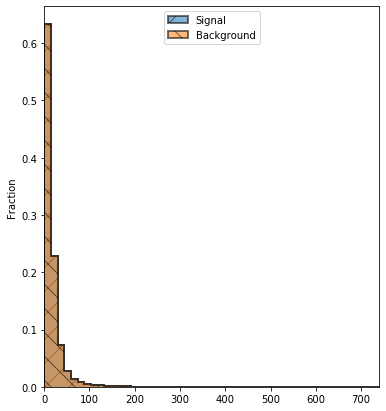

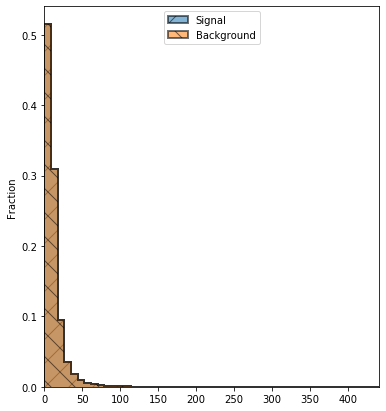

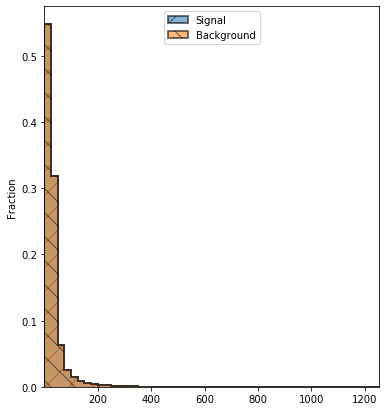

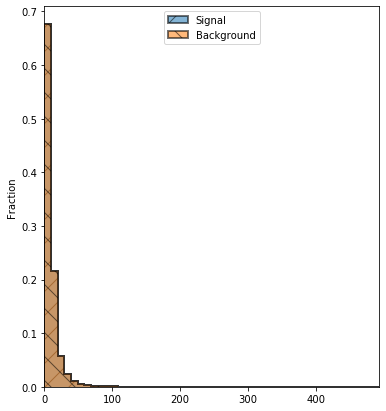

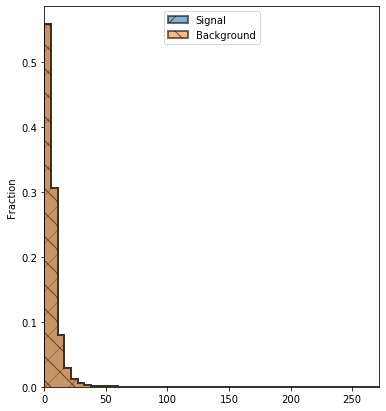

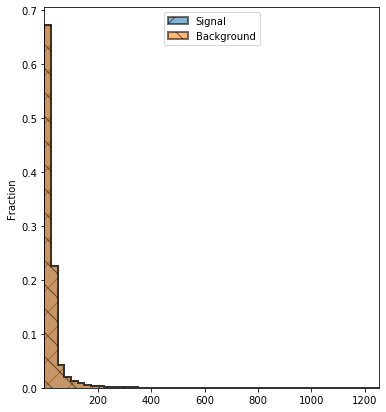

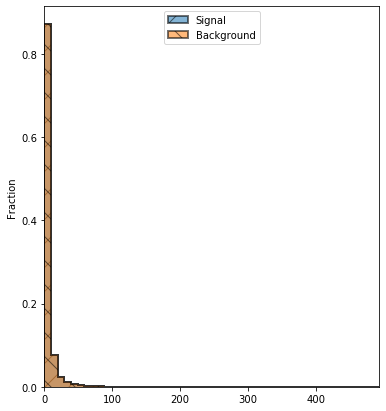

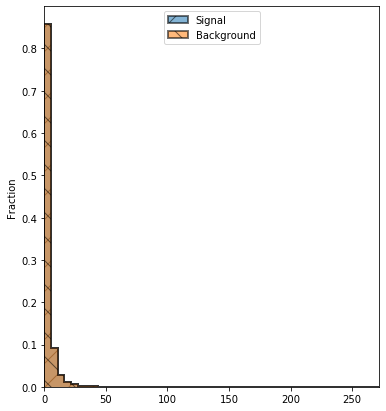

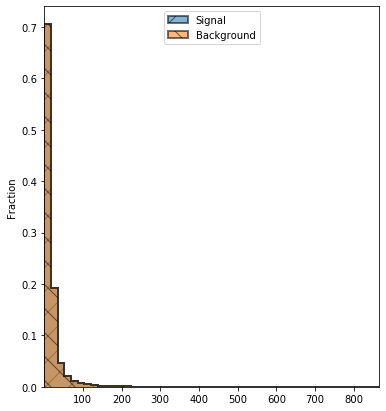

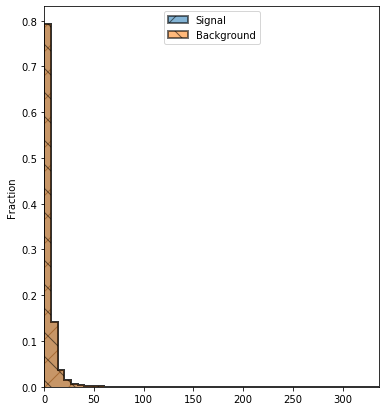

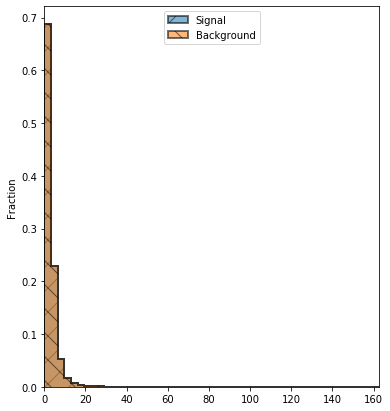

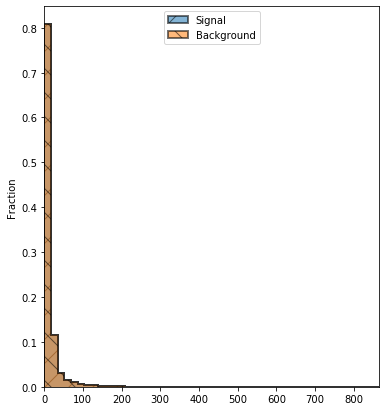

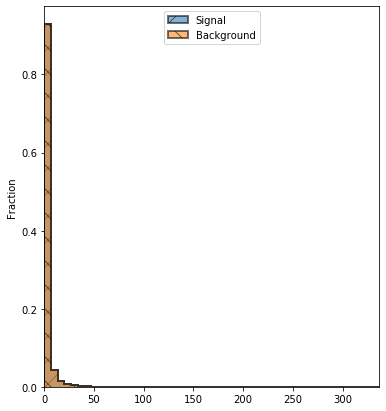

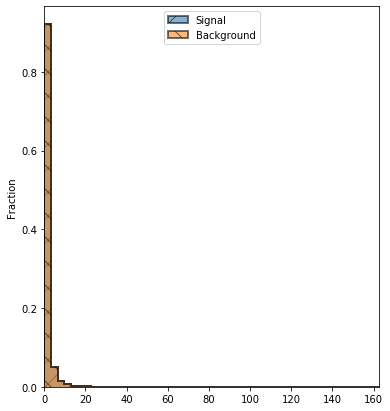

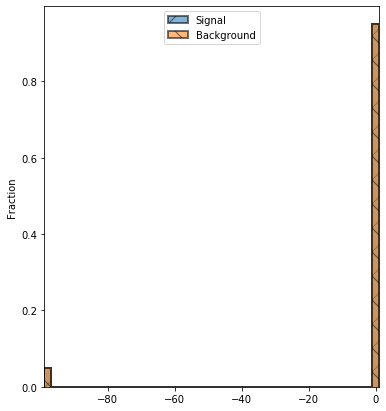

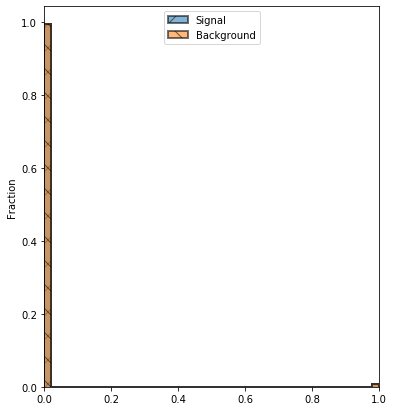

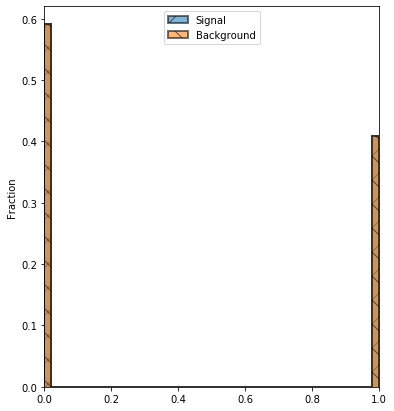

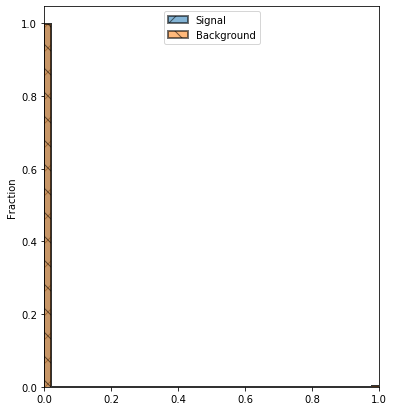

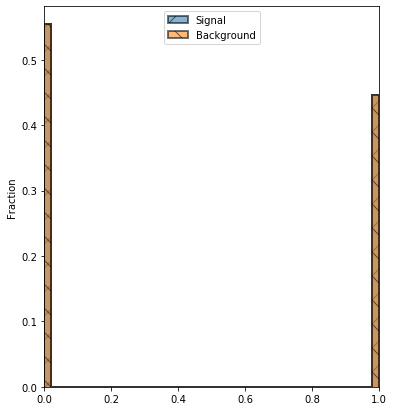

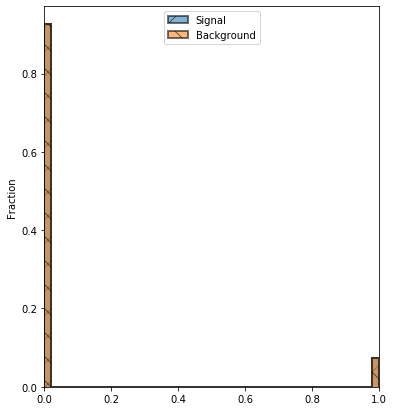

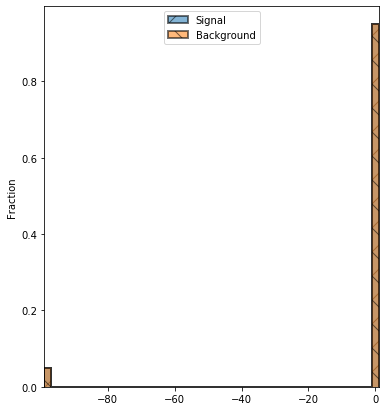

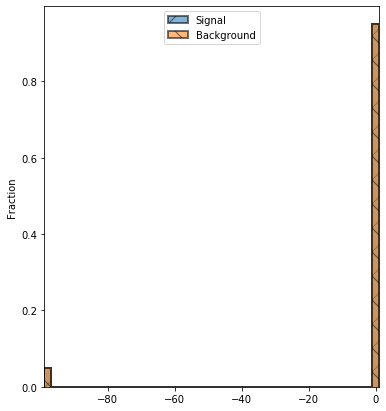

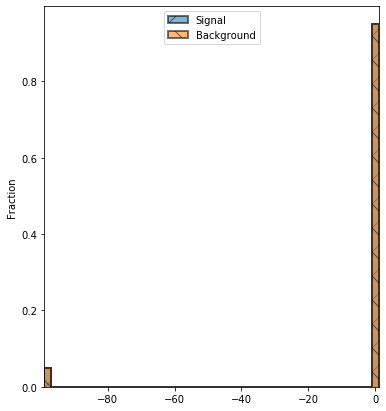

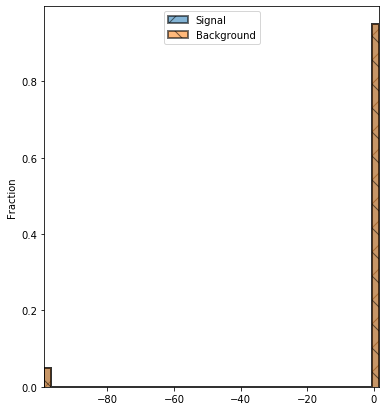

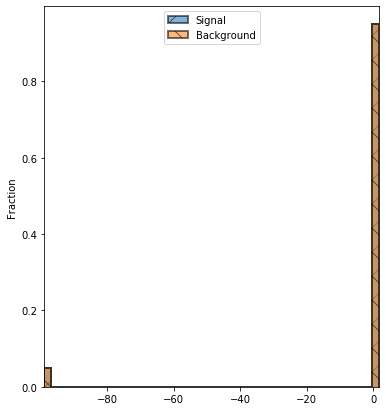

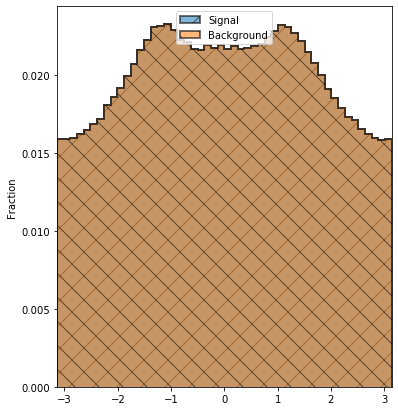

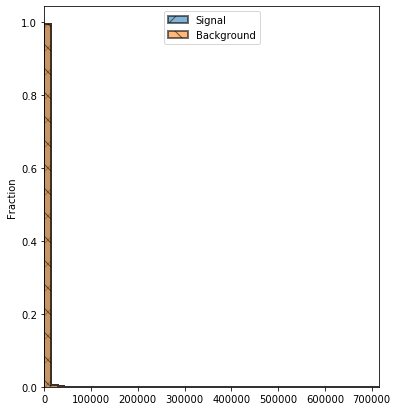

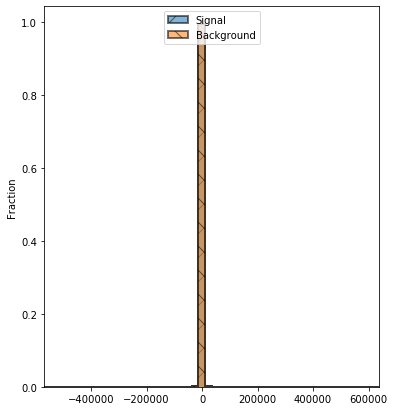

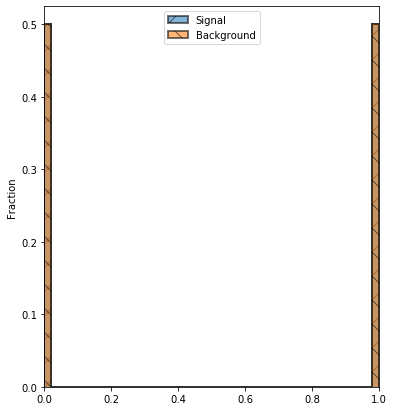

In [6]:
#ADD 3 STDEV PREPROCESSING
for key in data:
    plot_variable(data[key], data[key], 50)
print("Now add in rebinning")
for key in data:
    if key == 'labels':
        plot_variable(data[key], data[key], 50)
    else:
        std = np.std(data[key])
        mean = np.mean(data[key])
        data[key][data[key] > mean + 3*std] = mean + 3*std
        data[key][data[key] < mean - 3*std] = mean - 3*std
        plot_variable(data[key], data[key], 50)

In [7]:
z = np.argwhere(jetdata['labels'][:,1]==1)[:numData]
qcd = np.argwhere(jetdata['labels'][:,0]==1)[:numData]
split = int(0.8*numData)
train_id = np.concatenate((z[:split],qcd[:split]),axis=0).flatten()
np.random.shuffle(train_id)
test_id = np.concatenate((z[split:],qcd[split:]),axis=0).flatten()
# print(test_id)
np.random.shuffle(test_id)
# print(test_id)
data_train = {}
data_test = {}
#DIVIDE TAUS BY JET PT, GET RID OF NANs OR ADD EPSILON
for key in particle_list_vars:
    sub_train = data[key][train_id]
    sub_test = data[key][test_id]
    if key =='labels':
        data_train[key] = sub_train
        data_test[key] = sub_test
    else:
        minn = np.min(np.concatenate((sub_train,sub_test),axis=0),axis=0)
        maxx = np.max(np.concatenate((sub_train,sub_test),axis=0),axis=0)
        data_train[key] = (sub_train-minn)/(maxx-minn)
        data_test[key] = (sub_test-minn)/(maxx-minn)
    print(key, data_test[key].shape)
for key in xaugs:
    sub_train = jetdata[key][train_id]
    sub_test = jetdata[key][test_id]
    if key =='labels':
        data_train[key] = sub_train
        data_test[key] = sub_test
    else:
        minn = np.min(np.concatenate((sub_train,sub_test),axis=0),axis=0)
        maxx = np.max(np.concatenate((sub_train,sub_test),axis=0),axis=0)
        data_train[key] = (sub_train-minn)/(maxx-minn)
        data_test[key] = (sub_test-minn)/(maxx-minn)
    print(key, data_test[key].shape)

jetconstPt_log (353112, 20)
jetconstEta_abs (353112, 20)
jetconstE_log (353112, 20)
jetconstPt_Jetlog (353112, 20)
delta_eta (353112, 20)
delta_phi (353112, 20)
deltaR_jet (353112, 20)
deltaR_subjet0 (353112, 20)
deltaR_subjet1 (353112, 20)
dxy (353112, 20)
dz (353112, 20)
chMult (353112,)
jetpull (353112,)
tau2_b05 (353112,)
tau3_b05 (353112,)
tau2_sd_b05 (353112,)
tau3_sd_b05 (353112,)
jetMass (353112,)
jetMassSD (353112,)
labels (353112, 2)


In [8]:
print(data_test['labels'])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


Make variable plots

In [9]:
if not os.path.exists('data'):
    os.makedirs('data')
np.savez('data/RNN_full_train1.npz',**data_train)
np.savez('data/RNN_full_test1.npz',**data_test)